# Introduction
- feature enginearing part 1
- ref:
> https://www.kaggle.com/robikscube/exploring-molecular-properties-data

# Import everything I nead :)

In [6]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# set
plt.style.use('ggplot')
cmap = plt.get_cmap("tab10")

# MyFuncition

# Data Preparing

In [8]:
file_path = './input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['./input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 './input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 './input/champs-scalar-coupling/train.csv',
 './input/champs-scalar-coupling/mulliken_charges.csv',
 './input/champs-scalar-coupling/structures.csv',
 './input/champs-scalar-coupling/test.csv',
 './input/champs-scalar-coupling/structures']

In [9]:
# train
path = file_path + 'train.csv'
df_train = pd.read_csv(path)

In [10]:
# test
path = file_path + 'test.csv'
df_test = pd.read_csv(path)

In [11]:
# structure
path = file_path + 'structures.csv'
df_struct = pd.read_csv(path)

# Feature Engineering

**before**

In [12]:
df_train.head(1)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076


---
**after**

- atom_count を付与

In [13]:
atom_count_dict = df_struct.groupby('molecule_name').count()['atom_index'].to_dict()

In [14]:
df_train['atom_count'] = df_train['molecule_name'].map(atom_count_dict)
df_test['atom_count'] = df_test['molecule_name'].map(atom_count_dict)

- train data に **structure** データを付与

In [15]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, df_struct, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

df_train = map_atom_info(df_train, 0)
df_train = map_atom_info(df_train, 1)

df_test = map_atom_info(df_test, 0)
df_test = map_atom_info(df_test, 1)

In [16]:
df_train.head(1)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_count,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,5,H,0.00215,-0.006031,0.001976,C,-0.012698,1.085804,0.008001


- **distance** 情報を付与

In [17]:
# https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark
train_p_0 = df_train[['x_0', 'y_0', 'z_0']].values
train_p_1 = df_train[['x_1', 'y_1', 'z_1']].values
test_p_0 = df_test[['x_0', 'y_0', 'z_0']].values
test_p_1 = df_test[['x_1', 'y_1', 'z_1']].values

df_train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
df_test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

In [18]:
df_train.head(1)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_count,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,5,H,0.00215,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953


- **distance**をtypeごとの**distance**の平均値で割った値もついか
    - distance は typeごとに全く違う振る舞いをするから、とても理にかなっている

In [19]:
df_train['dist_to_type_mean'] = df_train['dist'] / df_train.groupby('type')['dist'].transform('mean')
df_test['dist_to_type_mean'] = df_test['dist'] / df_test.groupby('type')['dist'].transform('mean')

- カテゴリデータ(atom)を数値化

In [20]:
# make categorical variables
atom_map = {'H': 0,
            'C': 1,
            'N': 2}
df_train['atom_0_cat'] = df_train['atom_0'].map(atom_map).astype('int')
df_train['atom_1_cat'] = df_train['atom_1'].map(atom_map).astype('int')
df_test['atom_0_cat'] = df_test['atom_0'].map(atom_map).astype('int')
df_test['atom_1_cat'] = df_test['atom_1'].map(atom_map).astype('int')

In [21]:
df_train.head(1)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_count,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_to_type_mean,atom_0_cat,atom_1_cat
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,5,H,0.00215,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.999134,0,1


- One Hot Encode the **Type**

In [22]:
# One Hot Encode the Type
df_train = pd.concat([df_train, pd.get_dummies(df_train['type'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['type'])], axis=1)

In [23]:
df_train.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_count,atom_0,x_0,y_0,...,atom_0_cat,atom_1_cat,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,5,H,0.002150,-0.006031,...,0,1,1,0,0,0,0,0,0,0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,5,H,0.002150,-0.006031,...,0,0,0,0,0,1,0,0,0,0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,5,H,0.002150,-0.006031,...,0,0,0,0,0,1,0,0,0,0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,5,H,0.002150,-0.006031,...,0,0,0,0,0,1,0,0,0,0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,5,H,1.011731,1.463751,...,0,1,1,0,0,0,0,0,0,0


---
**plot**
- plot **distance** each **type!!**

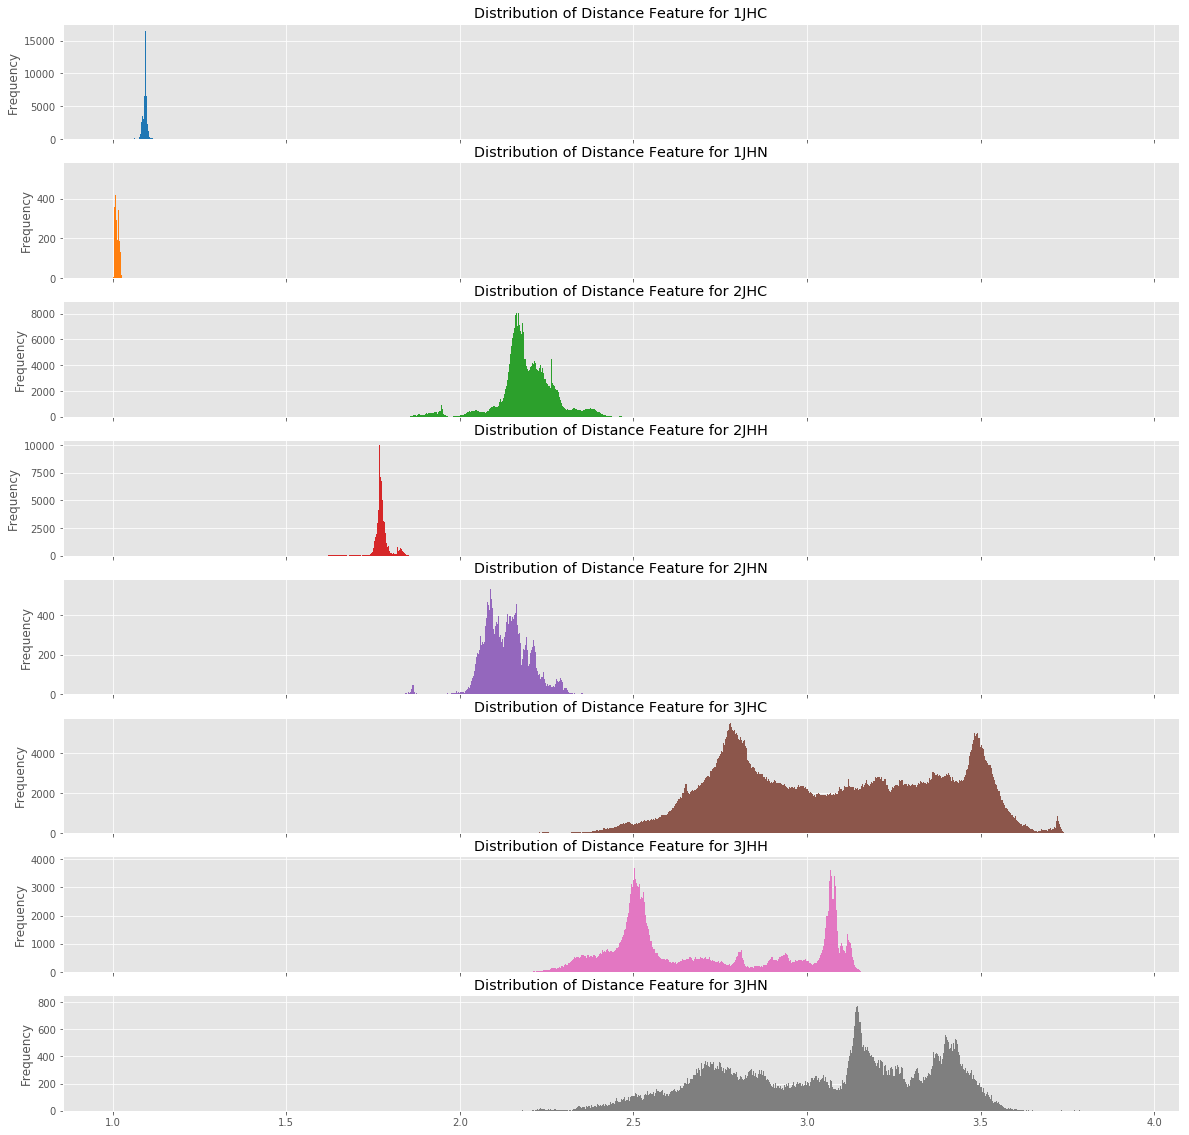

In [24]:
color_index = 0
axes_index = 0
fig, axes = plt.subplots(8, 1, figsize=(20, 20), sharex=True)
for mtype, d in df_train.groupby('type'):
    d['dist'].plot(kind='hist',
                  bins=1000,
                  title='Distribution of Distance Feature for {}'.format(mtype),
                  color=cmap(color_index),
                  ax=axes[axes_index])
    color_index += 1
    axes_index += 1
plt.show()

## check features!!

In [25]:
for x in df_train.columns:
    print(x)

id
molecule_name
atom_index_0
atom_index_1
type
scalar_coupling_constant
atom_count
atom_0
x_0
y_0
z_0
atom_1
x_1
y_1
z_1
dist
dist_to_type_mean
atom_0_cat
atom_1_cat
1JHC
1JHN
2JHC
2JHH
2JHN
3JHC
3JHH
3JHN


# save dataframe

In [26]:
path = './dataframe/20190609_nb10_train.csv'
df_train.to_csv(path, encoding='utf-8', index=False)

In [27]:
path = './dataframe/20190609_nb10_test.csv'
df_test.to_csv(path, encoding='utf-8', index=False)